In [16]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score # AUC score
from sklearn.metrics import average_precision_score # AUPR score
from sklearn.metrics import precision_recall_fscore_support # precision, recall
from imblearn.metrics import sensitivity_specificity_support # sensitivity, specificity
from sklearn.metrics import roc_curve # to draw auc curve
from sklearn.metrics import precision_recall_curve # to draw aupr curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NearMiss
from itertools import cycle
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# independent dataset
indep = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/new_predict/3_2_indep_descriptor.tsv")
indep_x = indep.values[:, 3:].astype(float)
indep_y = indep.values[:,2].astype(int)

In [18]:
#2017.04.12. PREDICT
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/new_predict/2_3_gold_descriptor.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [21]:
indep.head()

,drug_id,disease_id,association,drStr_diGe,drStr_diPhe,drPhe_diGe,drPhe_diPhe
0,DB00125,102300,0,0.988000,0.377060,0.988698,0.973507
1,DB00125,103780,0,0.984400,0.439811,0.984882,0.913192
2,DB00125,104300,0,0.968402,0.515095,0.968402,0.968303
3,DB00125,115195,0,0.986705,0.382821,0.987428,0.963070
4,DB00125,137580,0,0.989292,0.555586,0.989967,0.967168


In [26]:
indep[(indep.drug_id == 'DB00125') & (indep.disease_id == 102300)]

,drug_id,disease_id,association,drStr_diGe,drStr_diPhe,drPhe_diGe,drPhe_diPhe
0,DB00125,102300,0,0.988,0.37706,0.988698,0.973507


In [27]:
indep[(indep.drug_id == 'DB01200') & (indep.disease_id == 102300)]

,drug_id,disease_id,association,drStr_diGe,drStr_diPhe,drPhe_diGe,drPhe_diPhe
2094,DB01200,102300,1,0.828459,0.32257,0.972986,0.423237


In [19]:
# undersampler
rus = RandomUnderSampler()
oss = OneSidedSelection()
nm = NearMiss()

In [5]:
def Logistic_Regression_independent_graph(X, y, indep_X, indep_y, user_c):

    folds_results = dict()
    draw_results = {'fpr':[], 'tpr':[], 'precision_vec':[], 'recall_vec':[]}
    
    classifier = LogisticRegression(penalty='l1', C=user_c, n_jobs = -1)
    classifier.fit(X, y)
    indep_y_predicted_proba = classifier.predict_proba(indep_x)
    indep_y_predicted_label = classifier.predict(indep_x)

    # Accuracy
    indep_acc = classifier.score(indep_x, indep_y)
    folds_results['acc']=indep_acc
    
    # AUC
    indep_auc = roc_auc_score(indep_y, indep_y_predicted_proba[:,1])
    folds_results['auc']=indep_auc
    
    # Sensitivity, Specificity
    indep_sn, indep_sp, support = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    folds_results['sn']=indep_sn
    folds_results['sp']=indep_sp
    
    # AUPR
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:,1])
    folds_results['aupr']=indep_aupr
    
    # Precision, Recall
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    folds_results['precision']=indep_precision
    folds_results['recall']=indep_recall
    
    # Confusion Matirx
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    folds_results['confusion_matrix']=indep_confusion_matirx
    
    # draw graph
    indep_fpr, indep_tpr, thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label=1)
    draw_results['fpr'].append(indep_fpr)
    draw_results['tpr'].append(indep_tpr)
        
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    draw_results['precision_vec'].append(indep_precision_vec)
    draw_results['recall_vec'].append(indep_recall_vec)

    return folds_results, draw_results

In [6]:
def draw_plot(draw_results, final_result, user_c):
    #colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna']
    lw = 1
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    print "{}------------------------------------".format(user_c)
    for i in draw_results:
        for fpr, tpr in zip(i['fpr'], i['tpr']):
            ax1.plot(fpr, tpr, lw=lw)
        for recall_vec, precision_vec in zip(i['recall_vec'], i['precision_vec']):
            ax2.plot(recall_vec, precision_vec, lw=lw)
    ax1.set_xlabel('FPR')
    ax1.set_ylabel('TPR')
    ax1.set_color_cycle(colors)
    ax1.set_title('C={0}, Average AUC={1:0.2f}'.format(user_c, final_result['auc']))
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlim([0.0, 1.0])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_color_cycle(colors)
    ax2.set_title('C={0}, Average AUPR={1:0.2f}'.format(user_c, final_result['aupr']))
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    plt.tight_layout()
    plt.show()

In [7]:
def average_result(folds_results):
    avg_result = dict()
    avg_result['acc'] = sum(folds_results['acc']) / len(folds_results['acc'])
    avg_result['auc'] = sum(folds_results['auc']) / len(folds_results['auc'])
    avg_result['aupr'] = sum(folds_results['aupr']) / len(folds_results['aupr'])
    avg_result['sn'] = sum(folds_results['sn']) / len(folds_results['sn'])
    avg_result['sp'] = sum(folds_results['sp']) / len(folds_results['sp'])
    avg_result['precision'] = sum(folds_results['precision']) / len(folds_results['precision'])
    avg_result['recall'] = sum(folds_results['recall']) / len(folds_results['recall'])
    avg_result['confusion_matrix'] = sum(folds_results['confusion_matrix'])
    
    return avg_result

In [8]:
def seperate_results(indep_results):
    temp_results = {'acc':[], 'auc':[], 'aupr':[], 'confusion_matrix':[], 'sn':[], 'sp':[], 'precision':[], 'recall':[]}
    for i in range(independent_count):
        temp_results['acc'].append(indep_results[i]['acc'])
        temp_results['auc'].append(indep_results[i]['auc'])
        temp_results['aupr'].append(indep_results[i]['aupr'])
        temp_results['confusion_matrix'].append(indep_results[i]['confusion_matrix'])
        temp_results['sn'].append(indep_results[i]['sn'])
        temp_results['sp'].append(indep_results[i]['sp'])
        temp_results['precision'].append(indep_results[i]['precision'])
        temp_results['recall'].append(indep_results[i]['recall'])
    return temp_results

In [9]:
def write_output(fd, write_results, user_c):
    fd.write("C={}-------------------------------------------------\r\n".format(user_c))
    fd.write("Accuracy avg : {}\r\n".format(write_results['acc']))
    fd.write("AUC avg : {}\r\n".format(write_results['auc']))
    fd.write("  Sensitivity avg : {}\r\n".format(write_results['sn']))
    fd.write("  Specificity avg : {}\r\n".format(write_results['sp']))
    fd.write("AUPR avg : {}\r\n".format(write_results['aupr']))
    fd.write("  Precision avg : {}\r\n".format(write_results['precision']))
    fd.write("  Recall avg : {}\r\n".format(write_results['recall']))
    fd.write("confusion amtrix : {}\r\n".format(write_results['confusion_matrix']))

2017-04-14 16:13:28
1000------------------------------------


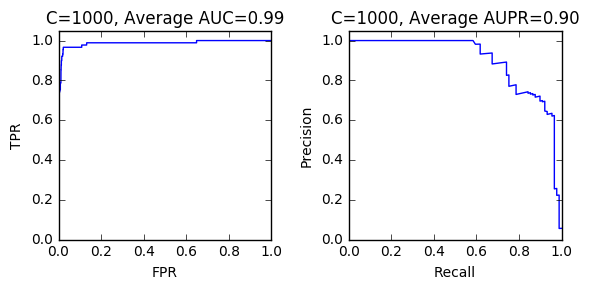

1000------------------------------------


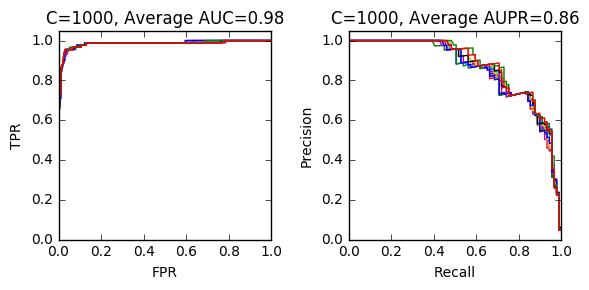

2017-04-14 16:14:19


In [20]:
# Logistic_Regression_independent_graph + 파일 입출력 + 1:1
# PREDICT original indep
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/new_predict/'
with open(path + "1_LR_indep.txt", 'w') as fd :
    user_c = 1000
    fd.write("<independent>\r\n")
    folds_results, draw_results = Logistic_Regression_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_c)
    draw_plot([draw_results], folds_results, user_c)
    write_output(fd, folds_results, user_c)
    #--------------------------------------------------------------
    fd.write("<1:1 independent>\r\n")
    independent_count = 10
    indep_results = dict()
    indep_draw = list()
    for i in range(independent_count):
        x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        folds_results2, draw_results2 = Logistic_Regression_independent_graph(x_resampled, y_resampled, indep_x, indep_y, user_c)
        indep_results[i] = folds_results2
        indep_draw.append(draw_results2)    
    seperated = seperate_results(indep_results)
    final_result = average_result(seperated)
    draw_plot(indep_draw, final_result, user_c)
    write_output(fd, final_result, user_c)    
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')